In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from transition_util import *
import multiprocessing as mp
import pickle
import os

In [2]:
if not(os.path.isfile("transitions1_xyz_multi_dict.pkl")) or not(os.path.isfile("transitions2_xyz_multi_dict.pkl")):
    landing_ac_data = pd.read_csv("../../landing_samples.csv",
                                  dtype = {"id": str, "lat": np.float16,
                                           "lon": np.float16, "ts": np.int32, "altitude": np.int32,
                                           "climb_rate": np.int16, "azimuth": np.int16,
                                           "ground_speed": np.int16, "jfk_landing_flag": bool,
                                           "source": str, "destination": str, "ground_flag": bool,
                                           "x": np.int8, "y": np.int8, "z": np.int8,
                                           "id_start_ts": np.int32, "id_end_ts": np.int32},
                                  usecols = ["id", "lat", "lon", "ts", "altitude", "climb_rate",
                                             "azimuth", "ground_speed", "jfk_landing_flag",
                                             "source", "destination", "ground_flag", "x", "y",
                                             "z", "id_start_ts", "id_end_ts"])
    landing_ac_data['x'] = landing_ac_data['x'].clip(0)
    landing_ac_data['y'] = landing_ac_data['y'].clip(0)
    landing_ac_data['z'] = landing_ac_data['z'].clip(0)

In [3]:
if not(os.path.isfile("transitions1_xyz_multi_dict.pkl")):
    # Retaining only aircraft IDs with destination == "JFK" in all rows
#     df1 = flight_data[flight_data['jfk_landing_flag']]
#     df1 = df1.sort_values(['id', 'ts']).reset_index(drop = True)
#     df1 = df1.groupby(['id']).apply(lambda x: (x['destination'] == "JFK").mean()).reset_index(drop = False)
#     df1 = df1[['id']][df1[0] == 1.0]
#     landing_ac_data = df1.merge(flight_data)
    landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)
    
    transitions1_xyz = {}
    delta_ts1 = {}
    condition = True
    previous_id = ''
    landing_ac_data['last_ts'] = landing_ac_data[['id', 'ts']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data['last_x'] = landing_ac_data[['id', 'x']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data['last_y'] = landing_ac_data[['id', 'y']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data['last_z'] = landing_ac_data[['id', 'z']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
#     landing_ac_data['last_lon'] = landing_ac_data[['id', 'lon']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
#     landing_ac_data['last_lat'] = landing_ac_data[['id', 'lat']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data['last_ground_speed'] = landing_ac_data[['id', 'ground_speed']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data['last_azimuth'] = landing_ac_data[['id', 'azimuth']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
#     landing_ac_data['last_climb_rate'] = landing_ac_data[['id', 'climb_rate']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
#     landing_ac_data['last_altitude'] = landing_ac_data[['id', 'altitude']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data = landing_ac_data[~landing_ac_data['last_ts'].apply(np.isnan)]
    landing_ac_data = landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)
    landing_ac_data = landing_ac_data[(landing_ac_data['last_x'] != landing_ac_data['x']) |
                              (landing_ac_data['last_y'] != landing_ac_data['y']) |
                              (landing_ac_data['last_z'] != landing_ac_data['z'])]
    landing_ac_data = landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)
    landing_ac_data['last_x'] = landing_ac_data['last_x'].apply(int)
    landing_ac_data['last_y'] = landing_ac_data['last_y'].apply(int)
    landing_ac_data['last_z'] = landing_ac_data['last_z'].apply(int)
    landing_ac_data['last_ground_speed'] = landing_ac_data['last_ground_speed'].apply(int)
    landing_ac_data['last_azimuth'] = landing_ac_data['last_azimuth'].apply(int)
    
    unit_time = 5
    start_df = landing_ac_data[['id', 'last_ts', 'last_x', 'last_y', 'last_z']].groupby(['id']).first().reset_index(drop = False)
    start_df.columns = ['id', 'start_ts', 'start_x', 'start_y', 'start_z']
    landing_ac_data = landing_ac_data.merge(start_df)
    landing_ac_data = landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)
    landing_ac_data['t'] = ((landing_ac_data['ts'] - landing_ac_data['start_ts'])/unit_time).apply(np.ceil).apply(int)
    landing_ac_data['last_t'] = ((landing_ac_data['last_ts'] - landing_ac_data['start_ts'])/unit_time).apply(np.ceil).apply(int)
    
    # Retaining only IDs that have successfully landed at JFK (small range)
    last_df = landing_ac_data.groupby(['id']).last().reset_index(drop = False)
    last_df['coords'] = last_df.apply(lambda x: (x['x'], x['y'], x['z']), axis = 1)
    last_df = last_df[last_df['coords'].apply(lambda x: x[2] <= 3)]
    print(last_df['coords'].value_counts())
    landing_ac_data = landing_ac_data.merge(last_df[['id']])
    landing_ac_data = landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)
    landed_xyz = set(last_df['coords'])
    print(landed_xyz)
    
#     for i in range(landing_ac_data.shape[0]):
#         id1 = landing_ac_data['id'].iloc[i]
#         last_x = landing_ac_data['last_x'].iloc[i]
#         last_y = landing_ac_data['last_y'].iloc[i]
#         last_z = landing_ac_data['last_z'].iloc[i]
#         last_ground_speed = landing_ac_data['last_ground_speed'].iloc[i]
#         last_azimuth = landing_ac_data['last_azimuth'].iloc[i]
#         last_ts = landing_ac_data['last_ts'].iloc[i]
#         x = landing_ac_data['x'].iloc[i]
#         y = landing_ac_data['y'].iloc[i]
#         z = landing_ac_data['z'].iloc[i]
#         ground_speed = landing_ac_data['ground_speed'].iloc[i]
#         azimuth = landing_ac_data['azimuth'].iloc[i]
#         ts = landing_ac_data['ts'].iloc[i]
#         condition = (previous_id != id1)
#         if (not((last_x, last_y, last_z) in landed_xyz) and condition):
#             last_row = True
#             try:
#                 transitions1_xyz[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))][((x, y, z), (ground_speed, azimuth))] += 1
#                 delta_ts1[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))][((x, y, z), (ground_speed, azimuth))] += [ts - last_ts]
#             except:
#                 try:
#                     transitions1_xyz[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))][((x, y, z), (ground_speed, azimuth))] = 1
#                     delta_ts1[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))][((x, y, z), (ground_speed, azimuth))] = [ts - last_ts]
#                 except:
#                     transitions1_xyz[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))] = {((x, y, z), (ground_speed, azimuth)): 1}
#                     delta_ts1[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))] = {((x, y, z), (ground_speed, azimuth)): [ts - last_ts]}
#         elif last_row:
#             previous_id = id1
# #             print(previous_id)
#             last_row = False
#             try:
#                 transitions1_xyz[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))][((x, y, z), (ground_speed, azimuth))] += 1
#                 delta_ts1[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))][((x, y, z), (ground_speed, azimuth))] += [ts - last_ts]
#             except:
#                 try:
#                     transitions1_xyz[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))][((x, y, z), (ground_speed, azimuth))] = 1
#                     delta_ts1[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))][((x, y, z), (ground_speed, azimuth))] = [ts - last_ts]
#                 except:
#                     transitions1_xyz[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))] = {((x, y, z), (ground_speed, azimuth)): 1}
#                     delta_ts1[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))] = {((x, y, z), (ground_speed, azimuth)): [ts - last_ts]}
    
#     pickle.dump(delta_ts1, open("delta_ts1.pkl", "wb"))
#     pickle.dump(transitions1_xyz, open("transitions1_xyz.pkl", "wb"))
#     pickle.dump(landed_xyz, open("landed_xyz.pkl", "wb"))
    
    
    for i in range(landing_ac_data.shape[0]):
        id1 = landing_ac_data['id'].iloc[i]
        last_x = landing_ac_data['last_x'].iloc[i]
        last_y = landing_ac_data['last_y'].iloc[i]
        last_z = landing_ac_data['last_z'].iloc[i]
        last_ground_speed = landing_ac_data['last_ground_speed'].iloc[i]
        last_azimuth = landing_ac_data['last_azimuth'].iloc[i]
        last_ts = landing_ac_data['last_ts'].iloc[i]
        x = landing_ac_data['x'].iloc[i]
        y = landing_ac_data['y'].iloc[i]
        z = landing_ac_data['z'].iloc[i]
        ground_speed = landing_ac_data['ground_speed'].iloc[i]
        azimuth = landing_ac_data['azimuth'].iloc[i]
        ts = landing_ac_data['ts'].iloc[i]
        condition = (previous_id != id1)
        if (not((last_x, last_y, last_z) in landed_xyz) and condition):
            last_row = True
            try:
                transitions1_xyz[(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)][(ground_speed, azimuth)] += 1
                delta_ts1[(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)][(ground_speed, azimuth)] += [ts - last_ts]
            except:
                try:
                    transitions1_xyz[(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)][(ground_speed, azimuth)] = 1
                    delta_ts1[(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)][(ground_speed, azimuth)] = [ts - last_ts]
                except:
                    try:
                        transitions1_xyz[(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)] = {(x, y, z): {(ground_speed, azimuth): 1}}
                        delta_ts1[(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)] = {(x, y, z): {(ground_speed, azimuth): [ts - last_ts]}}
                    except:
                        transitions1_xyz[(last_x, last_y, last_z)] = {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): 1}}}
                        delta_ts1[(last_x, last_y, last_z)] = {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): [ts - last_ts]}}}
        elif last_row:
            previous_id = id1
#             print(previous_id)
            last_row = False
            try:
                transitions1_xyz[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))][((x, y, z), (ground_speed, azimuth))] += 1
                delta_ts1[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))][((x, y, z), (ground_speed, azimuth))] += [ts - last_ts]
            except:
                try:
                    transitions1_xyz[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))][((x, y, z), (ground_speed, azimuth))] = 1
                    delta_ts1[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))][((x, y, z), (ground_speed, azimuth))] = [ts - last_ts]
                except:
                    transitions1_xyz[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))] = {((x, y, z), (ground_speed, azimuth)): 1}
                    delta_ts1[((last_x, last_y, last_z), (last_ground_speed, last_azimuth))] = {((x, y, z), (ground_speed, azimuth)): [ts - last_ts]}
    
    pickle.dump(delta_ts1, open("delta_ts1_multi_dict.pkl", "wb"))
    pickle.dump(transitions1_xyz, open("transitions1_xyz_multi_dict.pkl", "wb"))
    pickle.dump(landed_xyz, open("landed_xyz.pkl", "wb"))
else:
    transitions1_xyz = pickle.load(open("transitions1_xyz_multi_dict.pkl", "rb"))
    delta_ts1 = pickle.load(open("delta_ts1_multi_dict.pkl", "rb"))
    landed_xyz = pickle.load(open("landed_xyz.pkl", "rb"))



In [ ]:
if not(os.path.isfile("transitions2_xyz_multi_dict.pkl")):
    landing_ac_data['last_last_ts'] = landing_ac_data[['id', 'last_ts']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data['last_t'] = landing_ac_data[['id', 't']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data['last_last_x'] = landing_ac_data[['id', 'last_x']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data['last_last_y'] = landing_ac_data[['id', 'last_y']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data['last_last_z'] = landing_ac_data[['id', 'last_z']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data['last_last_ground_speed'] = landing_ac_data[['id', 'last_ground_speed']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data['last_last_azimuth'] = landing_ac_data[['id', 'last_azimuth']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
#     landing_ac_data['last_last_lon'] = landing_ac_data[['id', 'last_lon']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
#     landing_ac_data['last_last_lat'] = landing_ac_data[['id', 'last_lat']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
#     landing_ac_data['last_last_altitude'] = landing_ac_data[['id', 'last_altitude']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
#     landing_ac_data['last_last_climb_rate'] = landing_ac_data[['id', 'last_climb_rate']].set_index("id").groupby(level = "id").shift(1).reset_index(drop = True)
    landing_ac_data = landing_ac_data[~landing_ac_data['last_last_ts'].apply(np.isnan)]
    landing_ac_data = landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)
    landing_ac_data['last_last_x'] = landing_ac_data['last_last_x'].apply(int)
    landing_ac_data['last_last_y'] = landing_ac_data['last_last_y'].apply(int)
    landing_ac_data['last_last_z'] = landing_ac_data['last_last_z'].apply(int)
    landing_ac_data['last_last_ground_speed'] = landing_ac_data['last_last_ground_speed'].apply(int)
    landing_ac_data['last_last_azimuth'] = landing_ac_data['last_last_azimuth'].apply(int)
    landing_ac_data['last_last_t'] = ((landing_ac_data['last_last_ts'] - landing_ac_data['start_ts'])/unit_time).apply(np.ceil).apply(int)
    transitions2_xyz = {}
    delta_ts2 = {}
    previous_id = ''
#     for i in range(landing_ac_data.shape[0]):
#         last_last_x = landing_ac_data['last_last_x'].iloc[i]
#         last_last_y = landing_ac_data['last_last_y'].iloc[i]
#         last_last_z = landing_ac_data['last_last_z'].iloc[i]
#         last_last_ground_speed = landing_ac_data['last_last_ground_speed'].iloc[i]
#         last_last_azimuth = landing_ac_data['last_last_azimuth'].iloc[i]
#         last_last_ts = landing_ac_data['last_last_ts'].iloc[i]
#         last_x = landing_ac_data['last_x'].iloc[i]
#         last_y = landing_ac_data['last_y'].iloc[i]
#         last_z = landing_ac_data['last_z'].iloc[i]
#         last_ground_speed = landing_ac_data['last_ground_speed'].iloc[i]
#         last_azimuth = landing_ac_data['last_azimuth'].iloc[i]
#         last_ts = landing_ac_data['last_ts'].iloc[i]
#         id1 = landing_ac_data['id'].iloc[i]
#         x = landing_ac_data['x'].iloc[i]
#         y = landing_ac_data['y'].iloc[i]
#         z = landing_ac_data['z'].iloc[i]
#         ts = landing_ac_data['ts'].iloc[i]
#         condition = (previous_id != id1)
#         if not((x, y, z) in landed_xyz) and condition:
#             last_row = True
#             try:
#                 transitions2_xyz[(((last_last_x, last_last_y, last_last_z), (last_last_ground_speed, last_last_azimuth)), ((last_x, last_y, last_z), (last_ground_speed, last_azimuth)))][((x, y, z), (ground_speed, azimuth))] += 1
#                 delta_ts2[(((last_last_x, last_last_y, last_last_z), (last_last_ground_speed, last_last_azimuth)), ((last_x, last_y, last_z), (last_ground_speed, last_azimuth)))][(x, y, z)] += [ts - last_ts]
#             except:
#                 try:
#                     transitions2_xyz[(((last_last_x, last_last_y, last_last_z), (last_last_ground_speed, last_last_azimuth)), ((last_x, last_y, last_z), (last_ground_speed, last_azimuth)))][(x, y, z)] = 1
#                     delta_ts2[(((last_last_x, last_last_y, last_last_z), (last_last_ground_speed, last_last_azimuth)), ((last_x, last_y, last_z), (last_ground_speed, last_azimuth)))][(x, y, z)] = [ts - last_ts]
#                 except:
#                     transitions2_xyz[(((last_last_x, last_last_y, last_last_z), (last_last_ground_speed, last_last_azimuth)), ((last_x, last_y, last_z), (last_ground_speed, last_azimuth)))] = {(x, y, z): 1}
#                     delta_ts2[(((last_last_x, last_last_y, last_last_z), (last_last_ground_speed, last_last_azimuth)), ((last_x, last_y, last_z), (last_ground_speed, last_azimuth)))] = {(x, y, z): [ts - last_ts]}
#         elif last_row:
#             previous_id = id1
#             last_row = False
#             try:
#                 transitions2_xyz[(((last_last_x, last_last_y, last_last_z), (last_last_ground_speed, last_last_azimuth)), ((last_x, last_y, last_z), (last_ground_speed, last_azimuth)))][(x, y, z)] += 1
#                 delta_ts2[(((last_last_x, last_last_y, last_last_z), (last_last_ground_speed, last_last_azimuth)), ((last_x, last_y, last_z), (last_ground_speed, last_azimuth)))][(x, y, z)] += [ts - last_ts]
#             except:
#                 try:
#                     transitions2_xyz[(((last_last_x, last_last_y, last_last_z), (last_last_ground_speed, last_last_azimuth)), ((last_x, last_y, last_z), (last_ground_speed, last_azimuth)))][(x, y, z)] = 1
#                     delta_ts2[(((last_last_x, last_last_y, last_last_z), (last_last_ground_speed, last_last_azimuth)), ((last_x, last_y, last_z), (last_ground_speed, last_azimuth)))][(x, y, z)] = [ts - last_ts]
#                 except:
#                     transitions2_xyz[(((last_last_x, last_last_y, last_last_z), (last_last_ground_speed, last_last_azimuth)), ((last_x, last_y, last_z), (last_ground_speed, last_azimuth)))] = {(x, y, z): 1}
#                     delta_ts2[(((last_last_x, last_last_y, last_last_z), (last_last_ground_speed, last_last_azimuth)), ((last_x, last_y, last_z), (last_ground_speed, last_azimuth)))] = {(x, y, z): [ts - last_ts]}
    
    for i in range(landing_ac_data.shape[0]):
        last_last_x = landing_ac_data['last_last_x'].iloc[i]
        last_last_y = landing_ac_data['last_last_y'].iloc[i]
        last_last_z = landing_ac_data['last_last_z'].iloc[i]
        last_last_ground_speed = landing_ac_data['last_last_ground_speed'].iloc[i]
        last_last_azimuth = landing_ac_data['last_last_azimuth'].iloc[i]
        last_last_ts = landing_ac_data['last_last_ts'].iloc[i]
        last_x = landing_ac_data['last_x'].iloc[i]
        last_y = landing_ac_data['last_y'].iloc[i]
        last_z = landing_ac_data['last_z'].iloc[i]
        last_ground_speed = landing_ac_data['last_ground_speed'].iloc[i]
        last_azimuth = landing_ac_data['last_azimuth'].iloc[i]
        last_ts = landing_ac_data['last_ts'].iloc[i]
        id1 = landing_ac_data['id'].iloc[i]
        x = landing_ac_data['x'].iloc[i]
        y = landing_ac_data['y'].iloc[i]
        z = landing_ac_data['z'].iloc[i]
        ts = landing_ac_data['ts'].iloc[i]
        condition = (previous_id != id1)
        if not((x, y, z) in landed_xyz) and condition:
            last_row = True
            try:
                transitions2_xyz[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)][(ground_speed, azimuth)] += 1
                delta_ts2[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)][(ground_speed, azimuth)] += [ts - last_ts]
            except:
                try:
                    transitions2_xyz[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)][(ground_speed, azimuth)] = 1
                    delta_ts2[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)][(ground_speed, azimuth)] = [ts - last_ts]
                except:
                    try:
                        transitions2_xyz[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)] = {(ground_speed, azimuth): 1}
                        delta_ts2[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)] = {(ground_speed, azimuth): [ts - last_ts]}
                    except:
                        try:
                            transitions2_xyz[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)] = {(x, y, z): {(ground_speed, azimuth): 1}}
                            delta_ts2[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)] = {(x, y, z): {(ground_speed, azimuth): [ts - last_ts]}}
                        except:
                            try:
                                transitions2_xyz[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)] = {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): 1}}}
                                delta_ts2[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)] = {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): [ts - last_ts]}}}
                            except:
                                try:
                                    transitions2_xyz[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)] = {(last_x, last_y, last_z): {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): 1}}}}
                                    delta_ts2[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)] = {(last_x, last_y, last_z): {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): [ts - last_ts]}}}}
                                except:
                                    transitions2_xyz[(last_last_x, last_last_y, last_last_z)] = {(last_last_ground_speed, last_last_azimuth): {(last_x, last_y, last_z): {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): 1}}}}}
                                    delta_ts2[(last_last_x, last_last_y, last_last_z)] = {(last_last_ground_speed, last_last_azimuth): {(last_x, last_y, last_z): {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): [ts - last_ts]}}}}}
        elif last_row:
            previous_id = id1
            last_row = False
            try:
                transitions2_xyz[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)][(ground_speed, azimuth)] += 1
                delta_ts2[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)][(ground_speed, azimuth)] += [ts - last_ts]
            except:
                try:
                    transitions2_xyz[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)][(ground_speed, azimuth)] = 1
                    delta_ts2[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)][(ground_speed, azimuth)] = [ts - last_ts]
                except:
                    try:
                        transitions2_xyz[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)] = {(ground_speed, azimuth): 1}
                        delta_ts2[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)][(x, y, z)] = {(ground_speed, azimuth): [ts - last_ts]}
                    except:
                        try:
                            transitions2_xyz[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)] = {(x, y, z): {(ground_speed, azimuth): 1}}
                            delta_ts2[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)][(last_ground_speed, last_azimuth)] = {(x, y, z): {(ground_speed, azimuth): [ts - last_ts]}}
                        except:
                            try:
                                transitions2_xyz[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)] = {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): 1}}}
                                delta_ts2[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)][(last_x, last_y, last_z)] = {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): [ts - last_ts]}}}
                            except:
                                try:
                                    transitions2_xyz[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)] = {(last_x, last_y, last_z): {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): 1}}}}
                                    delta_ts2[(last_last_x, last_last_y, last_last_z)][(last_last_ground_speed, last_last_azimuth)] = {(last_x, last_y, last_z): {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): [ts - last_ts]}}}}
                                except:
                                    transitions2_xyz[(last_last_x, last_last_y, last_last_z)] = {(last_last_ground_speed, last_last_azimuth): {(last_x, last_y, last_z): {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): 1}}}}}
                                    delta_ts2[(last_last_x, last_last_y, last_last_z)] = {(last_last_ground_speed, last_last_azimuth): {(last_x, last_y, last_z): {(last_ground_speed, last_azimuth): {(x, y, z): {(ground_speed, azimuth): [ts - last_ts]}}}}}
    
    pickle.dump(transitions2_xyz, open("transitions2_xyz_multi_dict.pkl", "wb"))
    pickle.dump(delta_ts2, open("delta_ts2_multi_dict.pkl", "wb"))
else:
    transitions2_xyz = pickle.load(open("transitions2_xyz_multi_dict.pkl", "rb"))
    delta_ts2 = pickle.load(open("delta_ts2_multi_dict.pkl", "rb"))

In [ ]:
# Missed approaches: 06A11F_1, 0D0683_0, 4952A2_7, 4B187B_20, 71BE34_0, A01FEE_39, A3026F_7,
# A9F2C6_0, AAF87F_15, AB8F0D_10, ACA79D_0
# Probable jitter: 400F0B_3, 485789_2, A3D462_69, A8A785_64, AB0485_3, ABE930_6, ACB878_2, ADC934_16
# Other: 

In [4]:
# df1 = flight_data[flight_data['jfk_landing_flag']]
# # df1 = df1.sort_values(['id', 'ts']).reset_index(drop = True)
# df1 = df1.groupby(['id']).apply(lambda x: (x['destination'] == "JFK").mean()).reset_index(drop = False)
# df1 = df1[['id']][df1[0] == 1.0]
# landing_ac_data = df1.merge(flight_data)
landing_ac_data = pd.read_csv("../../landing_samples.csv")
landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)
landing_ac_data.drop(['id_start_ts', 'id_end_ts'], axis = 1)
first_df = landing_ac_data[['id', 'ts']].groupby(['id']).first().reset_index(drop = False)
last_df = landing_ac_data[['id', 'ts']].groupby(['id']).last().reset_index(drop = False)
first_df.columns = ['id', 'id_start_ts']
last_df.columns = ['id', 'id_end_ts']
landing_ac_data = landing_ac_data.merge(first_df)
landing_ac_data = landing_ac_data.merge(last_df)
landing_ac_data = landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)
landing_ac_data.head()

# Retaining only IDs that have successfully landed at JFK (small range)
last_df = landing_ac_data.groupby(['id']).last().reset_index(drop = False)
last_df['coords'] = last_df.apply(lambda x: (x['x'], x['y'], x['z']), axis = 1)
last_df = last_df[last_df['coords'].apply(lambda x: x[2] <= 3)]
print(last_df['coords'].value_counts())
landing_ac_data = landing_ac_data.merge(last_df[['id']])
landing_ac_data = landing_ac_data.sort_values(['id', 'ts']).reset_index(drop = True)

(39, 68, 0)    4147
(39, 69, 0)    3206
(38, 68, 0)      27
(40, 68, 0)      13
(40, 69, 0)       2
(38, 70, 0)       1
Name: coords, dtype: int64


In [15]:
# Simulating landing of 1 aircraft
uniq_id = landing_ac_data['id'].unique()
i = random.randint(a = 0, b = len(uniq_id) - 1)
chosen_id = uniq_id[i]
# chosen_id = "A3F04A_0"
dt = landing_ac_data['date'][landing_ac_data['id'] == chosen_id].iloc[0]
print(dt)

2019-06-19


In [16]:
flight_data = pd.read_csv("../../" + dt + ".csv", header = None)
tmp_dat = pd.read_csv("../../samples_with_jfk_landing_flag.csv", nrows = 1)
flight_data.columns = tmp_dat.columns

flight_data.sort_values(['id', 'ts']).reset_index(drop = True)
flight_data.drop(['id_start_ts', 'id_end_ts'], axis = 1)
first_df = flight_data[['id', 'ts']].groupby(['id']).first().reset_index(drop = False)
last_df = flight_data[['id', 'ts']].groupby(['id']).last().reset_index(drop = False)
first_df.columns = ['id', 'id_start_ts']
last_df.columns = ['id', 'id_end_ts']
flight_data = flight_data.merge(first_df)
flight_data = flight_data.merge(last_df)
flight_data = flight_data.sort_values(['id', 'ts']).reset_index(drop = True)


df = flight_data[flight_data['id'] == chosen_id].sort_values(['ts']).reset_index(drop = True).iloc[0]
df

date                          2019-06-19
id                              780E06_0
aircraft                          780E06
lat                              44.9897
lon                             -77.9783
ts                            1560931088
altitude                           35000
climb_rate                             0
azimuth                              143
ground_speed                         533
jfk_landing_flag                    True
source                               CAN
destination                          JFK
ground_flag                            0
x                                      1
y                                    121
z                                     70
id_end_ts                     1560934264
id_start_ts                   1560931088
ts_readable         2019-06-19T07:58:08Z
Name: 0, dtype: object

In [8]:
total_times = []
paths = []
max_landings = 10
landings = 0

def simulate_landing(df):
    landed = False
    total_time = 0
    path = []
    while not landed:
        path.append((df['x'], df['y'], df['z']))
        ts1 = df['ts']
        # We will not be able to know the complete duration of chosen aircraft before it actually lands
        temp_flight_data = flight_data[(flight_data['id_start_ts'] <= ts1) &
                                       (flight_data['id_end_ts'] >= ts1) &
                                       (flight_data['id'] != chosen_id)]
        last_known_df = temp_flight_data[temp_flight_data['ts'] <= ts1].reset_index(drop = True).groupby(['id']).last().reset_index(drop = False)
        last_known_df = last_known_df[(last_known_df['altitude'] > 0) | (last_known_df['climb_rate'] != 0)].reset_index(drop = True)
        current_df = last_known_df.apply(lambda x: get_current_pos(x, ts1), axis = 1)
    #     if total_time == 0:
    #         xyz_keys = [key for key in transitions1_xyz.keys() if key[0] == (df['x'], df['y'], df['z'])]
    #         nearest_ground_speed_azimuth = get_nearest_ground_speed_azimuth(df['ground_speed'], df['azimuth'], xyz_keys)
    #         print(nearest_ground_speed_azimuth)
    #         actions = transitions1_xyz[((df['x'], df['y'], df['z']), nearest_ground_speed_azimuth)]
    #         temp_delta_ts = delta_ts1[((df['x'], df['y'], df['z']), nearest_ground_speed_azimuth)]
    #     else:
    #         xyz_keys = [key for key in transitions2_xyz.keys() if key[1][0] == (df['x'], df['y'], df['z'])]
    #         nearest_ground_speed_azimuth = get_nearest_ground_speed_azimuth(df['ground_speed'], df['azimuth'], xyz_keys, two_dim_tuple = True)
    #         print(nearest_ground_speed_azimuth)
    #         actions = transitions2_xyz[(previous_state, (df['x'], df['y'], df['z']), nearest_ground_speed_azimuth)]
    #         temp_delta_ts = delta_ts2[(previous_state, (df['x'], df['y'], df['z']), nearest_ground_speed_azimuth)]
    #     xyz_keys = [key for key in transitions1_xyz.keys() if key == (df['x'], df['y'], df['z'])]
        list_grSpd_azi = list(transitions1_xyz[(df['x'], df['y'], df['z'])].keys())
        nearest_ground_speed_azimuth = get_nearest_ground_speed_azimuth(df['ground_speed'], df['azimuth'], list_grSpd_azi = list_grSpd_azi)
        actions = transitions1_xyz[(df['x'], df['y'], df['z'])][nearest_ground_speed_azimuth]
        temp_delta_ts = delta_ts1[(df['x'], df['y'], df['z'])][nearest_ground_speed_azimuth]
    #     print(xyz_keys[0][len(xyz_keys[0]) - 1])
    #     print(nearest_ground_speed_azimuth)
        next_xyzs = []
        for key in actions.keys():
            total = sum(list(actions[key].values()))
            next_xyzs.append(repeat(key, total))
        next_xyzs = unlist(next_xyzs)
        # This should probably change to greedy selection
        j = random.randint(a = 0, b = len(next_xyzs) - 1)
        next_xyz = next_xyzs[j]
        next_ground_speed_azimuth = list(actions[next_xyz].keys())
        j = random.randint(a = 0, b = len(next_ground_speed_azimuth) - 1)
        next_ground_speed_azimuth = next_ground_speed_azimuth[j]
        all_delta_ts = temp_delta_ts[next_xyz][next_ground_speed_azimuth]
        # This should probably change to greedy selection
        j = random.randint(a = 0, b = len(all_delta_ts) - 1)
        temp_delta_ts = all_delta_ts[j]
        df['ts'] = df['ts'] + temp_delta_ts
    #     previous_state = ((df['x'], df['y'], df['z']), (df['ground_speed'], df['azimuth']))
        total_time += temp_delta_ts
        df['x'] = next_xyz[0]
        df['y'] = next_xyz[1]
        df['z'] = next_xyz[2]
        df['ground_speed'] = next_ground_speed_azimuth[0]
        df['azimuth'] = next_ground_speed_azimuth[1]
        path.append(next_xyz)
        landed = (df['x'], df['y'], df['z']) in landed_xyz
        current_xyz = current_df.apply(convert_pos_to_xyz)
        collisions = current_xyz.apply(lambda x: check_collision(x, (df['x'], df['y'], df['z'])))
        if collisions.sum() > 0:
            print("Collision cannot be avoided between " + last_known_df['id'][collisions] + " and " + df['id'] + " at " + str(ts1))
            break
    return [path, total_time]


def simulate_landing_i(i):
    return simulate_landing(df)

In [ ]:
landed = False
total_time = 0
path = []
while not landed:
    path.append((df['x'], df['y'], df['z']))
    ts1 = df['ts']
    # We will not be able to know the complete duration of chosen aircraft before it actually lands
    temp_flight_data = flight_data[(flight_data['id_start_ts'] <= ts1) &
                                   (flight_data['id_end_ts'] >= ts1) &
                                   (flight_data['id'] != chosen_id)]
    last_known_df = temp_flight_data[temp_flight_data['ts'] <= ts1].reset_index(drop = True).groupby(['id']).last().reset_index(drop = False)
    last_known_df = last_known_df[(last_known_df['altitude'] > 0) | (last_known_df['climb_rate'] != 0)].reset_index(drop = True)
    current_df = last_known_df.apply(lambda x: get_current_pos(x, ts1), axis = 1)
    print(current_df.head())
#     if total_time == 0:
#         xyz_keys = [key for key in transitions1_xyz.keys() if key[0] == (df['x'], df['y'], df['z'])]
#         nearest_ground_speed_azimuth = get_nearest_ground_speed_azimuth(df['ground_speed'], df['azimuth'], xyz_keys)
#         print(nearest_ground_speed_azimuth)
#         actions = transitions1_xyz[((df['x'], df['y'], df['z']), nearest_ground_speed_azimuth)]
#         temp_delta_ts = delta_ts1[((df['x'], df['y'], df['z']), nearest_ground_speed_azimuth)]
#     else:
#         xyz_keys = [key for key in transitions2_xyz.keys() if key[1][0] == (df['x'], df['y'], df['z'])]
#         nearest_ground_speed_azimuth = get_nearest_ground_speed_azimuth(df['ground_speed'], df['azimuth'], xyz_keys, two_dim_tuple = True)
#         print(nearest_ground_speed_azimuth)
#         actions = transitions2_xyz[(previous_state, (df['x'], df['y'], df['z']), nearest_ground_speed_azimuth)]
#         temp_delta_ts = delta_ts2[(previous_state, (df['x'], df['y'], df['z']), nearest_ground_speed_azimuth)]
#     xyz_keys = [key for key in transitions1_xyz.keys() if key == (df['x'], df['y'], df['z'])]
    list_grSpd_azi = list(transitions1_xyz[(df['x'], df['y'], df['z'])].keys())
    nearest_ground_speed_azimuth = get_nearest_ground_speed_azimuth(df['ground_speed'], df['azimuth'], list_grSpd_azi = list_grSpd_azi)
#     print(nearest_ground_speed_azimuth)
    actions = transitions1_xyz[(df['x'], df['y'], df['z'])][nearest_ground_speed_azimuth]
    temp_delta_ts = delta_ts1[(df['x'], df['y'], df['z'])][nearest_ground_speed_azimuth]
#     print(xyz_keys[0][len(xyz_keys[0]) - 1])
#     print(nearest_ground_speed_azimuth)
    next_xyzs = []
    for key in actions.keys():
        total = sum(list(actions[key].values()))
        next_xyzs.append(repeat(key, total))
    next_xyzs = unlist(next_xyzs)
    # This should probably change to greedy selection
    j = random.randint(a = 0, b = len(next_xyzs) - 1)
    next_xyz = next_xyzs[j]
    next_ground_speed_azimuth = list(actions[next_xyz].keys())
    j = random.randint(a = 0, b = len(next_ground_speed_azimuth) - 1)
    next_ground_speed_azimuth = next_ground_speed_azimuth[j]
    all_delta_ts = temp_delta_ts[next_xyz][next_ground_speed_azimuth]
    # This should probably change to greedy selection
    j = random.randint(a = 0, b = len(all_delta_ts) - 1)
    temp_delta_ts = all_delta_ts[j]
    df['ts'] = df['ts'] + temp_delta_ts
#     previous_state = ((df['x'], df['y'], df['z']), (df['ground_speed'], df['azimuth']))
    total_time += temp_delta_ts
    df['x'] = next_xyz[0]
    df['y'] = next_xyz[1]
    df['z'] = next_xyz[2]
    df['ground_speed'] = next_ground_speed_azimuth[0]
    df['azimuth'] = next_ground_speed_azimuth[1]
    print(next_xyz, next_ground_speed_azimuth)
    landed = (df['x'], df['y'], df['z']) in landed_xyz


In [ ]:
df['azimuth'], xyz_keys[len(xyz_keys) - 1]

In [17]:
cores = max_landings
p = mp.Pool(processes = cores)
split_dfs = np.array_split([i for i in range(cores)], cores)
pool_results = p.map(simulate_landing_i, split_dfs)
p.close()
p.join()

In [ ]:
p.close()
p.join()

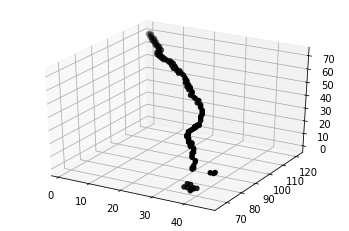

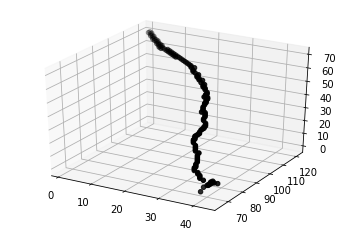

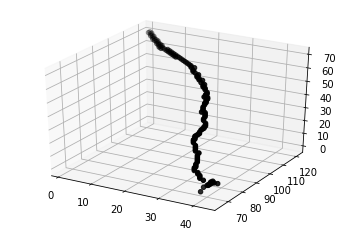

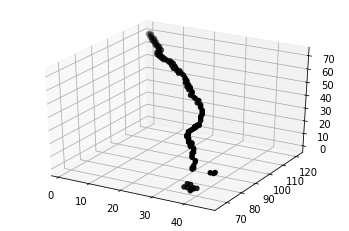

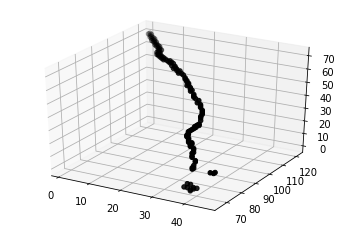

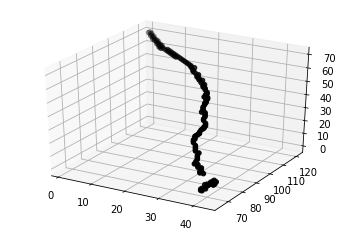

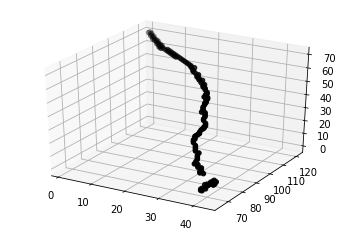

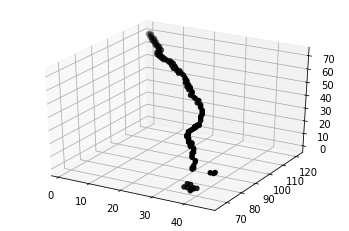

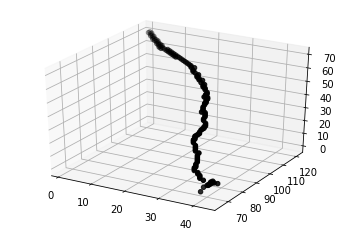

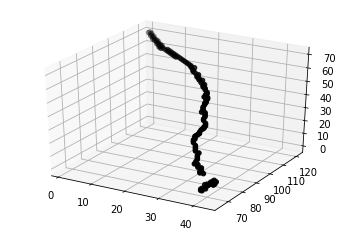

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
times = []
for i in range(len(pool_results)):
    res = pool_results[i]
    path = res[0]
    time = res[1]
    times.append(time)
    mat = np.zeros((flight_data['x'].max()+1, flight_data['y'].max()+1, flight_data['z'].max()+1))
    for coord in path:
        mat[coord[0], coord[1], coord[2]] += 1

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    pos = np.where(mat > 0)
    ax.scatter(pos[0], pos[1], pos[2], c='black')
    plt.show()

In [ ]:
flight_data.head()

In [ ]:
times

In [ ]:
# flight_data = pd.read_csv("../../samples_with_jfk_landing_flag.csv",
#                           dtype = {"id": str, "lat": np.float16,
#                                    "lon": np.float16, "ts": np.int32, "altitude": np.int32,
#                                    "climb_rate": np.int16, "azimuth": np.int16,
#                                    "ground_speed": np.int16, "jfk_landing_flag": bool,
#                                    "source": str, "destination": str, "ground_flag": bool,
#                                    "x": np.int8, "y": np.int8, "z": np.int8,
#                                    "id_start_ts": np.int32, "id_end_ts": np.int32},
#                           usecols = ["id", "lat", "lon", "ts", "altitude", "climb_rate",
#                                      "azimuth", "ground_speed", "jfk_landing_flag",
#                                      "source", "destination", "ground_flag", "x", "y",
#                                      "z", "id_start_ts", "id_end_ts"])

In [ ]:
# flight_data = flight_data.sort_values(by = ['id', 'ts']).reset_index(drop = True)
# # flight_data['jfk_landing_flag'] = (flight_data['jfk_landing_flag'] & (flight_data['destination'] == 'JFK'))
# flight_data['lon'] = flight_data['lon'].clip(-78, -68)
# flight_data['lat'] = flight_data['lat'].clip(35, 45)
# flight_data['altitude'] = flight_data['altitude'].clip(0, 50000)
# flight_data['x'] = ((flight_data['lon'] + 78) * 10).apply(np.ceil).apply(int)
# flight_data['y'] = ((flight_data['lat'] - 35) * 10).apply(np.ceil).apply(int)
# flight_data['z'] = ((flight_data['altitude']) / 500).apply(np.ceil).apply(int)

In [ ]:
# flight_data.head()

In [ ]:
# flight_data = pd.read_csv("../../samples_with_jfk_landing_flag.csv")
# flight_data = flight_data.sort_values(['id', 'ts']).reset_index(drop = True)
# print(flight_data.shape)
# start_df = flight_data[['id', 'ts']].groupby(['id']).first().reset_index(drop = False)
# end_df = flight_data[['id', 'ts']].groupby(['id']).last().reset_index(drop = False)
# start_df.columns = ['id', 'id_start_ts']
# end_df.columns = ['id', 'id_end_ts']
# flight_data = flight_data.merge(start_df)
# flight_data = flight_data.merge(end_df)
# flight_data = flight_data.sort_values(['id', 'ts']).reset_index(drop = True)
# print(flight_data.shape)

In [ ]:
# lis1 = [transitions1_xyz[key].values() for key in transitions1_xyz.keys()]
# lis2 = unlist(lis1)
# lis2 = pd.Series(lis2)
# print(lis2.value_counts())
# print(len(lis2))

In [ ]:
# lis1 = [transitions2_xyz[key].values() for key in transitions2_xyz.keys()]
# lis2 = unlist(lis1)
# lis2 = pd.Series(lis2)
# print(lis2.value_counts())
# print(len(lis2))

In [ ]:
# list(transitions1_xyz.keys())[0:10]

In [ ]:
# while landings < max_landings:
#     landed = False
#     total_time = 0
#     df = flight_data[flight_data['id'] == chosen_id].iloc[0]
#     path = []
#     print(df[['id', 'ts', 'x', 'y', 'z']])
#     while not landed:
#         path.append((df['x'], df['y'], df['z']))
#         ts1 = df['ts']
#         print(ts1)
#         # We will not be able to know the complete duration of chosen aircraft before it actually lands
#         temp_flight_data = flight_data[(flight_data['id_start_ts'] <= ts1) &
#                                        (flight_data['id_end_ts'] >= ts1) &
#                                        (flight_data['id'] != chosen_id)]
#         temp_flight_data.shape
#         last_known_df = temp_flight_data[temp_flight_data['ts'] <= ts1].reset_index(drop = True).groupby(['id']).last().reset_index(drop = False)
#         last_known_df = last_known_df[(last_known_df['altitude'] > 0) | (last_known_df['climb_rate'] != 0)].reset_index(drop = True)
#         current_df = last_known_df.apply(lambda x: get_current_pos(x, ts1), axis = 1)
#         if total_time == 0:
#             actions = transitions1_xyz[(df['x'], df['y'], df['z'])]
#             temp_delta_ts = delta_ts1[(df['x'], df['y'], df['z'])]
#         else:
#             actions = transitions2_xyz[(previous_state, (df['x'], df['y'], df['z']))]
#             temp_delta_ts = delta_ts2[(previous_state, (df['x'], df['y'], df['z']))]
#         next_xyzs = [repeat(key, actions[key]) for key in actions.keys()]
#         next_xyzs = unlist(next_xyzs)
#         # This should probably change to greedy selection
#         j = random.randint(a = 0, b = len(next_xyzs) - 1)
#         next_xyz = next_xyzs[j]
#         print(next_xyz)
#         all_delta_ts = temp_delta_ts[next_xyz]
#         # This should probably change to greedy selection
#         j = random.randint(a = 0, b = len(all_delta_ts) - 1)
#         temp_delta_ts = all_delta_ts[j]
#         df['ts'] = df['ts'] + temp_delta_ts
#         previous_state = (df['x'], df['y'], df['z'])
#         total_time += temp_delta_ts
#         df['x'] = next_xyz[0]
#         df['y'] = next_xyz[1]
#         df['z'] = next_xyz[2]
#         landed = (df['x'], df['y'], df['z']) in landed_xyz
    
#     total_times.append(total_time)
#     landings += 1

In [ ]:
# [(key, transitions1_xyz[key]) for key in transitions1_xyz.keys() if key[0] == (1, 6, 74)]

In [ ]:
# temp_delta_ts

In [ ]:
# list_grSpd_azi

In [ ]:
# xyz_keys = [key for key in transitions1_xyz.keys() if key[0] == (df['x'], df['y'], df['z'])]